In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import pinocchio as pin
from pinocchio.visualize import MeshcatVisualizer
from meshcat.transformations import translation_matrix, rotation_matrix
from meshcat.geometry import Box, MeshPhongMaterial, Cylinder
from scipy.optimize import minimize

### Visualization

In [2]:
# specify a path the the urdf files and meshes
urdf_model_path = "diffdrive.urdf"
mesh_dir = ""

# load the robot using pinocchio
robot = pin.RobotWrapper.BuildFromURDF(urdf_model_path, mesh_dir)

# vizualize the robot using meshcat
viz = MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(loadModel=True)

def show_robot(x,y,theta):
    quat = pin.Quaternion(pin.utils.rotate('z', theta)).coeffs()
    pos = np.array([x,y,0.1])

    viz.display(np.append(pos,quat))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [3]:
# Add a floor
# Add floor material
material_floor = MeshPhongMaterial()
material_floor.color = int(200) * 256**2 + int(200) * 256 + int(200)
# Add a floor
viz.viewer["/Floor"].set_object(
    Box([10, 10, 0.01]),
    material_floor
)
viz.viewer["/Floor"].set_transform(
    translation_matrix([0, 0, -0.005])
)

# Add obstacle material
material_obstacle = MeshPhongMaterial()
material_obstacle.color = int(100) * 256**2 + int(100) * 256 + int(100)

# Randomly generate 10 obstacle positions within a defined range
SEED = 6
np.random.seed(SEED) #6
obstacle_positions = [
    np.array([np.random.uniform(-4.8, 4.8), np.random.uniform(-4.8, 4.8), 0.5])
    for _ in range(10)
] # 10 obstacles, defined as x, y, z positions
print("Obstacle 1:", obstacle_positions[0])
print(len(obstacle_positions[0]))

# add cylinders for each obstacle
for i, pos in enumerate(obstacle_positions):
    viz.viewer[f"/Obstacle_{i}"].set_object(
        Cylinder(1, 0.2), material_obstacle
    )
    T_world_obs = translation_matrix(pos)
    T_world_obs[:3, :3] = pin.utils.rotate('x', np.pi / 2)
    viz.viewer[f"/Obstacle_{i}"].set_transform(
        T_world_obs
    )

# Add walls between obstacles, for every two obstacles
for i, pos in enumerate(obstacle_positions[::2]):
    # Connect a wall (box) between the two obstacles
    wall_length = np.linalg.norm(obstacle_positions[2*i][:2] - obstacle_positions[2*i+1][:2])
    wall_width = 0.4
    wall_height = 1.0
    wall_material = MeshPhongMaterial()
    wall_material.color = int(100) * 256**2 + int(100) * 256 + int(100)

    wall_position = (obstacle_positions[2*i][:2] + obstacle_positions[2*i+1][:2]) / 2

    viz.viewer[f"/Wall_Obstacle_{i}"].set_object(
        Box([wall_length, wall_width, wall_height]), wall_material
    )
    # Set the wall rotation to align with the line between the two obstacles
    angle = np.arctan2(
        obstacle_positions[2*i+1][1] - obstacle_positions[2*i][1],
        obstacle_positions[2*i+1][0] - obstacle_positions[2*i][0]
    )
    viz.viewer[f"/Wall_Obstacle_{i}"].set_transform(
        translation_matrix([wall_position[0], wall_position[1], wall_height / 2]) @
        rotation_matrix(angle, [0, 0, 1])
    )

# Add walls around the floor
wall_thickness = 0.1
wall_height = 1.0

# Left wall
viz.viewer["/Wall_Left"].set_object(Box([wall_thickness, 10, wall_height]))
viz.viewer["/Wall_Left"].set_transform(
    translation_matrix([-5 - wall_thickness / 2, 0, wall_height / 2])
)

# Right wall
viz.viewer["/Wall_Right"].set_object(Box([wall_thickness, 10, wall_height]))
viz.viewer["/Wall_Right"].set_transform(
    translation_matrix([5 + wall_thickness / 2, 0, wall_height / 2])
)

# Front wall
viz.viewer["/Wall_Front"].set_object(Box([10, wall_thickness, wall_height]))
viz.viewer["/Wall_Front"].set_transform(
    translation_matrix([0, 5 + wall_thickness / 2, wall_height / 2])
)

# Back wall
viz.viewer["/Wall_Back"].set_object(Box([10, wall_thickness, wall_height]))
viz.viewer["/Wall_Back"].set_transform(
    translation_matrix([0, -5 - wall_thickness / 2, wall_height / 2])
)

# can you add a tower in each corner of the walls?
tower_height = 1.5
tower_radius = 0.3
tower_material = MeshPhongMaterial()
tower_material.color = int(100) * 256**2 + int(100) * 256 + int(100)

tower_positions = [
    np.array([-5 - wall_thickness / 2, 5 + wall_thickness / 2, tower_height / 2]),
    # first element is the x position, second is the y position, third is the z position
    np.array([5 + wall_thickness / 2, 5 + wall_thickness / 2, tower_height / 2]),
    np.array([-5 - wall_thickness / 2, -5 - wall_thickness / 2, tower_height / 2]),
    np.array([5 + wall_thickness / 2, -5 - wall_thickness / 2, tower_height / 2])
]

for i, pos in enumerate(tower_positions):
    viz.viewer[f"/Tower_{i}"].set_object(
        Cylinder(tower_height, tower_radius), tower_material
    )
    T_world_tower = translation_matrix(pos)
    T_world_tower[:3, :3] = pin.utils.rotate('x', np.pi / 2)
    viz.viewer[f"/Tower_{i}"].set_transform(
        T_world_tower
    )

Obstacle 1: [ 3.77145745 -1.61299387  0.5       ]
3


In [4]:
""" 
Initalize parameters for the robot
"""

RADIUS = 0.3  # Radius of the robot (from the URDF)
START = [0, 0, 0]  # Starting position of the robot
x, y, theta = START
# grid is:
# x [-5, 5]
# y [-5, 5]
# theta [0, 2*pi]
show_robot(x,y,theta)

### Simulation

In [5]:
# Define robot dynamics
def discrete_dynamics(state, control_input, dt, model_mismatch=False):
    """
    Update the robot's state based on its dynamics.

    Parameters:
    - state: Current state [x, y, theta]
    - control_input: Control input [linear_velocity, angular_velocity]
    - dt: Time step

    Returns:
    - Updated state [x, y, theta]
    """
    x, y, theta = state
    linear_velocity, angular_velocity = control_input
    if model_mismatch:
        # Introduce model mismatch by adding noise to the control input
        linear_velocity += np.random.normal(0, 1.0)
        angular_velocity += np.random.normal(0, 1.0)

    # Update state using differential drive kinematics
    x += linear_velocity * np.cos(theta) * dt
    y += linear_velocity * np.sin(theta) * dt
    theta += angular_velocity * dt

    # Normalize theta to keep it within [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))

    return np.array([x, y, theta])


In [6]:
def simulation(controller):
    # Simulation parameters
    dt = 0.01  # Time step (s)
    simulation_time = 10  # Total simulation time (s)
    sensor_noise_stddev = 0.03  # Standard deviation of sensor noise (m)

    # Initial robot position and orientation
    x, y, theta = START  # Initial position (x, y) and orientation (theta)

    # Simulation loop
    for t in np.arange(0, simulation_time, dt):

        z = np.array([x,y]) + np.random.normal(0, sensor_noise_stddev, 2)  # Simulated sensor measurement with noise

        # calculate control inputs
        u,w = controller(x,y,theta,z)
        # u = linear_velocity
        # w = angular_velocity

        # Update robot position and orientation using differential drive kinematics
        x, y, theta = discrete_dynamics([x, y, theta], [u,w], dt, model_mismatch=False)

        # Normalize theta to keep it within [-pi, pi]
        theta = np.arctan2(np.sin(theta), np.cos(theta))

        # Display the robot in the visualization
        show_robot(x, y, theta)
        # Calculate and visualize distances to towers

        # Pause to simulate real-time visualization
        time.sleep(dt)

# Motion Planning

from
https://github.com/AtsushiSakai/PythonRobotics/blob/master/PathPlanning/ProbabilisticRoadMap/probabilistic_road_map.py

### Optimization-Based Local Planner (Ignoring Obstacles)

In [ ]:
from scipy.optimize import minimize

def compute_final_state(start, v, omega, t):
    """
    Function to compute the final state of the robot given the initial state,
    linear velocity, angular velocity, and time duration.
    
    Parameters:
    - start: Initial state [x0, y0, theta0]
    - v: Linear velocity
    - omega: Angular velocity
    - t: Time duration
    Returns:
    - Final state [x, y, theta]
    """
    
    x0, y0, theta0 = start
    if np.isclose(omega, 0.0):
        x = x0 + v * t * np.cos(theta0)
        y = y0 + v * t * np.sin(theta0)
        theta = theta0
    else:
        theta = theta0 + omega * t
        theta = np.arctan2(np.sin(theta), np.cos(theta))  # Normalize
        x = x0 + (v / omega) * (np.sin(theta) - np.sin(theta0))
        y = y0 + (v / omega) * (np.cos(theta0) - np.cos(theta))
    return np.array([x, y, theta])

def local_planner(start, goal, robot_radius=RADIUS):
    """
    Local planner to compute the optimal linear and angular velocities
    to reach a goal position while ignoring obstacles.
    Uses optimization to find the best velocities and time duration.
    
    Parameters:
    - start: Initial state [x0, y0, theta0]
    - goal: Goal state [x_goal, y_goal, theta_goal]
    - robot_radius: Radius of the robot (default is 1.0)
    Returns:
    - v_opt: Optimal linear velocity
    - omega_opt: Optimal angular velocity
    - t_opt: Optimal time duration
    - path: List of positions (x, y) along the path to the goal
    """
    def objective(variables):
        v, omega, t = variables
        final_state = compute_final_state(start, v, omega, t)
        error = final_state - goal
        return np.sum(error**2)
    
    dx = goal[0] - start[0]
    dy = goal[1] - start[1]
    distance = np.hypot(dx, dy)
    initial_theta = np.arctan2(dy, dx)
    initial_v = distance / 1.0 if distance > 0 else 0.0
    initial_omega = (initial_theta - start[2]) / 1.0
    initial_guess = [initial_v, initial_omega, 1.0]
    
    bounds = [(-1.0, 1.0), (-3.0, 3.0), (0.1, 5.0)]
    result = minimize(objective, initial_guess, bounds=bounds, method='SLSQP')
    
    if not result.success:
        return None, None, None, []
    
    v_opt, omega_opt, t_opt = result.x
    dt = 0.1
    time_steps = int(t_opt / dt)
    path = []
    current_state = np.array(start)
    for _ in range(time_steps):
        current_state = discrete_dynamics(current_state, [v_opt, omega_opt], dt, model_mismatch=False)
        path.append(current_state[:2])
    return v_opt, omega_opt, t_opt, path

### Collision Check Function

In [8]:
def distance_point_to_segment(p, a, b):
    """ 
    Calculate the distance from point p to the line segment defined by points a and b.
    Parameters:
    - p: Point (x, y) as a numpy array
    - a: Start point of the segment (x, y) as a numpy array
    - b: End point of the segment (x, y) as a numpy array
    Returns:
    - Distance from point p to the segment ab.
    """
    ap = p - a # Vector from a to p
    ab = b - a # Vector from a to b
    t = np.dot(ap, ab) / (np.dot(ab, ab) + 1e-8) # Project p onto line ab
    # 1e-8 is added to avoid division by zero
    t = np.clip(t, 0.0, 1.0) # Clamp projection to the segment [a, b]
    closest = a + t * ab # Closest point on the segment to p
    return np.linalg.norm(p - closest) # Euclidean distance

def is_collision(path, obstacles, robot_radius=RADIUS):
    """ 
    Check if the path collides with any obstacles.
    Parameters:
    - path: List of points representing the path [(x1, y1), (x2, y2), ...]
    - obstacles: List of obstacles, each defined by a tuple (start, end, radius)
                 where start and end are points defining the obstacle segment
                 and radius is the radius of the obstacle.
    - robot_radius: Radius of the robot (default is 1.0)
    Returns:
    - True if the path collides with any obstacle, False otherwise.
    """
    for (x, y) in path:
        for (start, end, radius) in obstacles:
            distance = distance_point_to_segment(np.array([x, y]), np.array(start), np.array(end))
            if distance < (robot_radius + radius):
                return True
    return False

### PRM

In [9]:
from scipy.spatial import KDTree

class Node:
    """
    Node class for dijkstra search
    """

    def __init__(self, x, y, cost, parent_index):
        self.x = x
        self.y = y
        self.cost = cost
        self.parent_index = parent_index

    def __str__(self):
        return str(self.x) + "," + str(self.y) + "," +\
               str(self.cost) + "," + str(self.parent_index)
               
def sample_points(sx, sy, gx, gy, robot_radius, obstacles, rng=None):
    """
    This function samples points in the environment while avoiding obstacles.
    It generates random points within a defined range and checks for collisions
    with obstacles. The function returns a list of sampled points including the
    start and goal positions.
    Parameters:
    - sx: Start x-coordinate
    - sy: Start y-coordinate
    - gx: Goal x-coordinate
    - gy: Goal y-coordinate
    - robot_radius: Radius of the robot
    - obstacles: List of obstacles defined as tuples (start, end, radius)
    - rng: Random number generator (optional)
    Returns:
    - sample_x: List of 500 sampled x-coordinates + [sx, gx]
    - sample_y: List of 500 sampled y-coordinates + [sy, gy]
    """
    min_x, max_x = -5, 5
    min_y, max_y = -5, 5
    sample_x, sample_y = [], []
    rng = np.random.default_rng() if rng is None else rng
    while len(sample_x) < 500: # sample 500 points
        tx = rng.uniform(min_x, max_x)
        ty = rng.uniform(min_y, max_y)
        if not is_collision([(tx, ty)], obstacles, robot_radius):
            sample_x.append(tx)
            sample_y.append(ty)
    sample_x += [sx, gx]
    sample_y += [sy, gy]
    return sample_x, sample_y

def generate_road_map(sample_x, sample_y, robot_radius, obstacles):
    """
    Generate a road map (graph) from sampled points. (PRM)
    This function creates a road map by connecting sampled points with edges
    based on local planning. It uses a KDTree for efficient nearest neighbor search
    and checks for collisions with obstacles. Each sampled point is connected to
    its nearest neighbors, forming a graph structure.
    Parameters:
    - sample_x: List of sampled x-coordinates
    - sample_y: List of sampled y-coordinates
    - robot_radius: Radius of the robot
    - obstacles: List of obstacles defined as tuples (start, end, radius)
    Returns:
    - road_map: List of edges for each sampled point, where each edge is a list of indices
                of connected points. Each index corresponds to a point in sample_x and sample_y.
    """
    N_NEAREST_NODES = 20  # number of nearest neighbors to connect
    road_map = []
    sample_kd_tree = KDTree(np.vstack((sample_x, sample_y)).T)
    # intialize fast nearest-neighbor lookup from all sample points
    for i in range(len(sample_x)):
        ix, iy = sample_x[i], sample_y[i]
        dists, indexes = sample_kd_tree.query([ix, iy], k=len(sample_x))
        # indexes = indices of all points sorted by distance
        edge_id = []
        for j in indexes[1:]: # skip the first point (itself)
            nx, ny = sample_x[j], sample_y[j]
            start_theta = np.arctan2(ny - iy, nx - ix) # angle to the point
            goal_theta = start_theta # orientation of the robot
            start = [ix, iy, start_theta]
            goal = [nx, ny, goal_theta]
            _, _, _, path = local_planner(start, goal, robot_radius)
            if path and not is_collision(path, obstacles, robot_radius):
                edge_id.append(j)
            if len(edge_id) >= N_NEAREST_NODES:
                break
        road_map.append(edge_id)
    return road_map

def dijkstra_planning(sx, sy, gx, gy, road_map, sample_x, sample_y):
    """ 
    Dijkstra's algorithm for path planning.
    This function implements Dijkstra's algorithm to find the shortest path
    from the start node to the goal node in a road map. It uses a priority queue
    to explore nodes based on their cost and maintains a closed set of visited nodes.
    Parameters:
    - sx: Start x-coordinate
    - sy: Start y-coordinate
    - gx: Goal x-coordinate
    - gy: Goal y-coordinate
    - road_map: List of edges for each sampled point, where each edge is a list of indices
    - sample_x: List of sampled x-coordinates
    - sample_y: List of sampled y-coordinates
    Returns:
    - rx: List of x-coordinates of the path from start to goal
    - ry: List of y-coordinates of the path from start to goal
    """
    start_node = Node(sx, sy, 0.0, -1) # x, y, cost, parent_index
    goal_node = Node(gx, gy, 0.0, -1)
    # open = unvisited nodes, closed = visited nodes
    open_set, closed_set = {len(sample_x)-2: start_node}, {} # start node and empty closed set
    
    # Continue until all reachable nodes are visited or goal is found
    while open_set:
        c_id = min(open_set, key=lambda k: open_set[k].cost)
        current = open_set[c_id]
        if c_id == len(sample_x)-1:
            rx, ry = [current.x], [current.y]
            while current.parent_index != -1:
                current = closed_set[current.parent_index]
                rx.append(current.x)
                ry.append(current.y)
            return rx[::-1], ry[::-1]
        del open_set[c_id] # remove current node from open set
        closed_set[c_id] = current # add current node to closed set
        for n_id in road_map[c_id]: # iterate over neighbors
            dx = sample_x[n_id] - current.x
            dy = sample_y[n_id] - current.y
            d = np.hypot(dx, dy)
            node = Node(sample_x[n_id], sample_y[n_id], current.cost + d, c_id)
            if n_id in closed_set:
                continue
            if n_id in open_set:
                if open_set[n_id].cost > node.cost:
                    open_set[n_id] = node
            else:
                open_set[n_id] = node
    return [], []

### full motion planner

/home/thibault/miniconda3/envs/py13roboticscourse/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/home/thibault/miniconda3/envs/py13roboticscourse/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


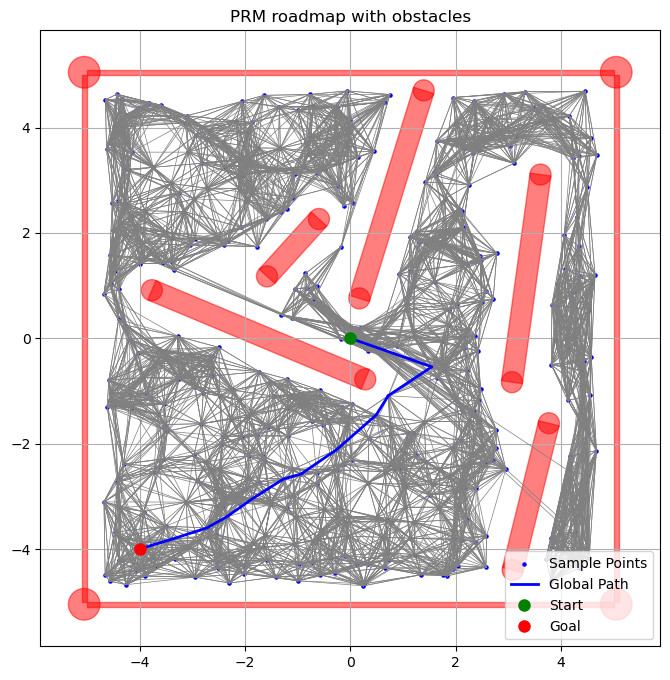

In [10]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
import matplotlib.transforms as transforms

def get_obstacles():
    """ 
    Obstacles are defined as a list of tuples, where each tuple contains:
    - start point (x, y)
    - end point (x, y)
    - radius (for cylindrical obstacles)
    The obstacles are defined as follows:
    1. Individual cylindrical obstacles (radius = 0.2)
    2. Walls between obstacle pairs (width = 0.4 -> radius = 0.2)
    3. Boundary walls (thickness = 0.1 -> radius = 0.05)
    4. Corner towers (radius = 0.3)
    """
    obstacles = []

    # 1. Individual cylindrical obstacles (radius = 0.2)
    for pos in obstacle_positions:
        x, y = pos[0], pos[1]
        obstacles.append(((x, y), (x, y), 0.2))  # Zero-length capsule (circle)

    # 2. Walls between obstacle pairs (width = 0.4 -> radius = 0.2)
    for i in range(len(obstacle_positions) // 2):
        start_obs = obstacle_positions[2*i]
        end_obs = obstacle_positions[(2*i)+1]
        start = (start_obs[0], start_obs[1])
        end = (end_obs[0], end_obs[1])
        obstacles.append((start, end, 0.2))

    # 3. Boundary walls (thickness = 0.1 -> radius = 0.05)
    obstacles.extend([
        # Left wall (x=-5.05)
        ((-5.05, -5), (-5.05, 5), 0.05),
        # Right wall (x=5.05)
        ((5.05, -5), (5.05, 5), 0.05),
        # Front wall (y=5.05)
        ((-5, 5.05), (5, 5.05), 0.05),
        # Back wall (y=-5.05)
        ((-5, -5.05), (5, -5.05), 0.05)
    ])

    # 4. Corner towers (radius = 0.3)
    for pos in tower_positions:
        x, y = pos[0], pos[1]
        obstacles.append(((x, y), (x, y), 0.3))

    return obstacles

class MotionPlanner:
    def __init__(self, start, goal, obstacles):
        self.obstacles = obstacles
        self.robot_radius = RADIUS
        self.sample_x, self.sample_y = sample_points(start[0], start[1], goal[0], goal[1], self.robot_radius, obstacles)
        self.road_map = generate_road_map(self.sample_x, self.sample_y, self.robot_radius, obstacles)
        self.global_path_x, self.global_path_y = dijkstra_planning(start[0], start[1], goal[0], goal[1], self.road_map, self.sample_x, self.sample_y)
        self.current_idx = 0

    def get_control(self, x, y, theta):
        """
        Returns the control inputs (linear and angular velocities) for the robot
        to follow the global path towards the next waypoint.
        If the robot is close enough to the next waypoint, it moves to the next one.
        Parameters:
        - x: Current x position of the robot
        - y: Current y position of the robot
        - theta: Current orientation of the robot (in radians)
        Returns:
        - v: Linear velocity to apply
        - omega: Angular velocity to apply
        """
        if self.current_idx >= len(self.global_path_x) - 1:
            return 0.0, 0.0
        target_x = self.global_path_x[self.current_idx + 1]
        target_y = self.global_path_y[self.current_idx + 1]
        start = [x, y, theta]
        goal_theta = np.arctan2(target_y - y, target_x - x)
        goal = [target_x, target_y, goal_theta]
        v, omega, _, _ = local_planner(start, goal, self.robot_radius)
        if np.hypot(target_x - x, target_y - y) < 0.3:  # If close enough to the next waypoint
            self.current_idx += 1
        return v, omega
    
    def plot_road_map(self):
        plt.figure(figsize=(8, 8))
        plt.axis("equal")

        # Plot roadmap nodes
        plt.scatter(self.sample_x, self.sample_y, s=5, c="blue", label="Sample Points")

        # Plot roadmap edges
        for i, neighbors in enumerate(self.road_map):
            ix, iy = self.sample_x[i], self.sample_y[i]
            for j in neighbors:
                jx, jy = self.sample_x[j], self.sample_y[j]
                plt.plot([ix, jx], [iy, jy], "gray", linewidth=0.5)

        # Plot obstacles
        for (start, end, radius) in self.obstacles:
            if start == end:  # Circle (cylinder or tower)
                circle = Circle(start, radius, color="red", alpha=0.5)
                plt.gca().add_patch(circle)
            else:
                dx = end[0] - start[0]
                dy = end[1] - start[1]
                length = np.hypot(dx, dy)
                angle = np.arctan2(dy, dx)
                center_x = (start[0] + end[0]) / 2
                center_y = (start[1] + end[1]) / 2

                # Create unrotated rectangle
                box = Rectangle(
                    (-length / 2, -radius),  # lower-left corner (local coords)
                    width=length,
                    height=radius * 2,
                    color="red",
                    alpha=0.5
                )

                # Rotate and move the rectangle to its position
                t = transforms.Affine2D().rotate(angle).translate(center_x, center_y) + plt.gca().transData
                box.set_transform(t)
                plt.gca().add_patch(box)
            
        # Plot global path
        plt.plot(self.global_path_x, self.global_path_y, "b-", linewidth=2, label="Global Path")

        # Plot start and goal
        plt.plot(self.sample_x[-2], self.sample_y[-2], "go", label="Start", markersize=8)
        plt.plot(self.sample_x[-1], self.sample_y[-1], "ro", label="Goal", markersize=8)

        plt.legend()
        plt.title("PRM roadmap with obstacles")
        plt.grid(True)
        plt.show()

# Initialize planner with start and goal
start = START
goal = [-4, -4, np.pi/2]
obstacles = get_obstacles()
planner = MotionPlanner(start, goal, obstacles)
planner.plot_road_map()

def controller(x, y, theta, z):
    return planner.get_control(z[0], z[1], theta)

simulation(controller)